In [1]:
import os
import random
import sys
import numpy as np

In [2]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path='/content/drive'
  base_folder = "/Data/FX"
  data_folder = f'{mount_path}/My Drive{base_folder}'
  drive.mount(mount_path)
else:
  base_folder = '../../Data/'
  data_folder = os.path.join(base_folder, "FX", "OANDA-Japan MT5 Live")

In [3]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../modules'

sys.path.append(module_path)

import fprocess

In [4]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_name = f"mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

open     high      low    close  tick_volume  spread  \
time                                                                           
2014-07-07 08:30:00  102.086  102.122  102.081  102.102          738       3   
2014-07-07 09:00:00  102.102  102.146  102.098  102.113         1036       3   
2014-07-07 09:30:00  102.113  102.115  102.042  102.044          865       3   
2014-07-07 10:00:00  102.047  102.052  102.005  102.019          983       3   
2014-07-07 10:30:00  102.017  102.025  101.918  101.941         1328       3   
...                      ...      ...      ...      ...          ...     ...   
2022-08-12 21:30:00  133.461  133.506  133.439  133.484         1125       3   
2022-08-12 22:00:00  133.484  133.530  133.437  133.475         1277       3   
2022-08-12 22:30:00  133.475  133.486  133.433  133.483         1506       3   
2022-08-12 23:00:00  133.484  133.536  133.465  133.521         1038       3   
2022-08-12 23:30:00  133.521  133.522  133.301  133.313         2515       3   

                     real_volume  
time                              
2014-07-07 08:30:00            0  
2014-07-07 09:00:00            0  
2014-07-07 09:30:00            0  
2014-07-07 10:00:00            0  
2014-07-07 10:30:00            0  
...                          ...  
2022-08-12 21:30:00            0  
2022-08-12 22:00:00            0  
2022-08-12 22:30:00            0  
2022-08-12 23:00:00            0  
2022-08-12 23:30:00            0  

[100720 rows x 7 columns]

# K-Means

In [5]:
columns = [*ohlc_column, "spread"]
src_df = df[columns].copy()

diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [diff_p]
processes = [*ohlc_pre_process]

for process in processes:
  src_df = process(src_df)

In [7]:
def k_means(src_df, label_num_k, initial_centers = None, max_iter = 10000):
  np.random.seed(100)
  random.seed(100)
  
  count = 0

  labels = np.fromiter(random.choices(range(label_num_k), k=src_df.shape[0]), dtype = int)
  labels_prev = np.zeros(src_df.shape[0])
  if initial_centers is None:
    cluster_centers = np.eye(label_num_k, src_df.shape[1])
  else:
    initial_centers = np.array(initial_centers)
    if initial_centers.shape == (label_num_k, src_df.shape[1]):
      cluster_centers = initial_centers
    else:
      raise ValueError("invalid initial centeers")

  while (not (labels == labels_prev).all()):
      for i in range(label_num_k):
          clusters = src_df.iloc[labels == i]
          if len(clusters) > 0:
            cluster_centers[i, :] = clusters.mean(axis = 0)
          else:
            cluster_centers[i, :] = np.ones(src_df.shape[1])
      dist = ((src_df.values[:, :, np.newaxis] - cluster_centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
      # dist = np.sqrt(dist)
      labels_prev = labels
      labels = dist.argmin(axis = 1)
      count += 1
      if count > max_iter:
        break
  return labels, cluster_centers

## Clustering with quantile values

Since difference vectors of finance data are almost exists around zero vector initial centers randomly generated typically handle vectors around zero as one cluster. To intently avoid that, I specify initial centers with quantile values.

In [7]:
label_num_k = 30
divisions = [i / (label_num_k-1) for i in range(label_num_k)]
token_df = src_df[["open", "close"]].dropna()
ini_centers = [
    np.quantile(token_df, p, axis=0) for p in divisions
]
ini_centers

[array([-2.398, -2.398]),
 array([-0.145, -0.144]),
 array([-0.101, -0.101]),
 array([-0.078, -0.078]),
 array([-0.063, -0.063]),
 array([-0.052, -0.051]),
 array([-0.043, -0.042]),
 array([-0.035, -0.035]),
 array([-0.029, -0.029]),
 array([-0.023, -0.023]),
 array([-0.018, -0.018]),
 array([-0.013, -0.013]),
 array([-0.009, -0.009]),
 array([-0.005, -0.005]),
 array([-0.001, -0.001]),
 array([0.003, 0.003]),
 array([0.007, 0.007]),
 array([0.011, 0.011]),
 array([0.015, 0.015]),
 array([0.02, 0.02]),
 array([0.025, 0.025]),
 array([0.031, 0.031]),
 array([0.037, 0.037]),
 array([0.045, 0.045]),
 array([0.054, 0.053]),
 array([0.064, 0.064]),
 array([0.079, 0.079]),
 array([0.1, 0.1]),
 array([0.142, 0.142]),
 array([1.502, 1.501])]

In [8]:
labels, centers = k_means(token_df, label_num_k=len(ini_centers), initial_centers=ini_centers)

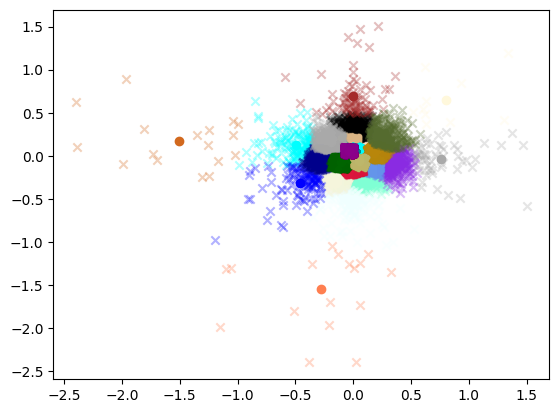

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

colors = [*mcolors.CSS4_COLORS.values()]

for label in range(len(centers)):
    label_df = token_df.loc[labels == label]
    plt.scatter(label_df["open"], label_df["close"], color=colors[label], marker="x", alpha=0.3)
    plt.scatter(centers[label][0], centers[label][1], color=colors[label])
plt.show()

We can label a new vector by clustering centers

In [10]:
def random_token():
    return np.random.random(2) * 2 - 1

In [11]:
def to_label(token, centers):
    if len(token.shape) == 1:
        token = np.reshape(token, (1, token.shape[0]))
    dist = ((token - centers) ** 2).sum(axis = 1)
    label = dist.argmin(axis = 0)
    return label

In [40]:
token = random_token()
label = to_label(token, centers)
print(token)
print(label)

[-0.15096482  0.68955226]
11


Check if clusterd values obey normal distribution

In [41]:
label_df = token_df.loc[labels == label]
center = centers[label]
c_diff = label_df - center
mean = c_diff.mean()
std = c_diff.std()
l_min = c_diff.min()
l_max = c_diff.max()

In [42]:
c_diff.describe()

open         close
count  7.900000e+01  7.900000e+01
mean  -2.810691e-18  5.059244e-17
std    1.520761e-01  2.233883e-01
min   -5.867215e-01 -2.002911e-01
25%   -5.522152e-02 -1.472911e-01
50%    1.227848e-02 -6.729114e-02
75%    7.177848e-02  5.720886e-02
max    3.652785e-01  8.117089e-01

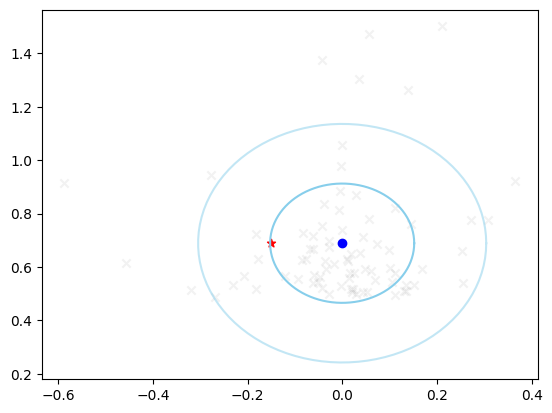

In [43]:
theta = np.linspace(0, 2*np.pi, 100)

x_circle = center[0] + std["open"] * np.cos(theta)
y_circle = center[1] + std["close"] * np.sin(theta)
x_circle_2 = center[0] + std["open"] *2* np.cos(theta)
y_circle_2 = center[1] + std["close"] *2* np.sin(theta)

plt.scatter(label_df["open"], label_df["close"], color='gray', marker="x", alpha=0.1)
plt.plot(x_circle, y_circle,  color='skyblue')
plt.plot(x_circle_2, y_circle_2,  color='skyblue', alpha=0.5)
# center is plotted with "o"
plt.scatter(center[0], center[1], color='blue')
# actual vector
plt.scatter(token[0], token[1], color="r", marker="*")
plt.show()

C:\Users\sato\AppData\Local\Temp\ipykernel_21052\2244095607.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


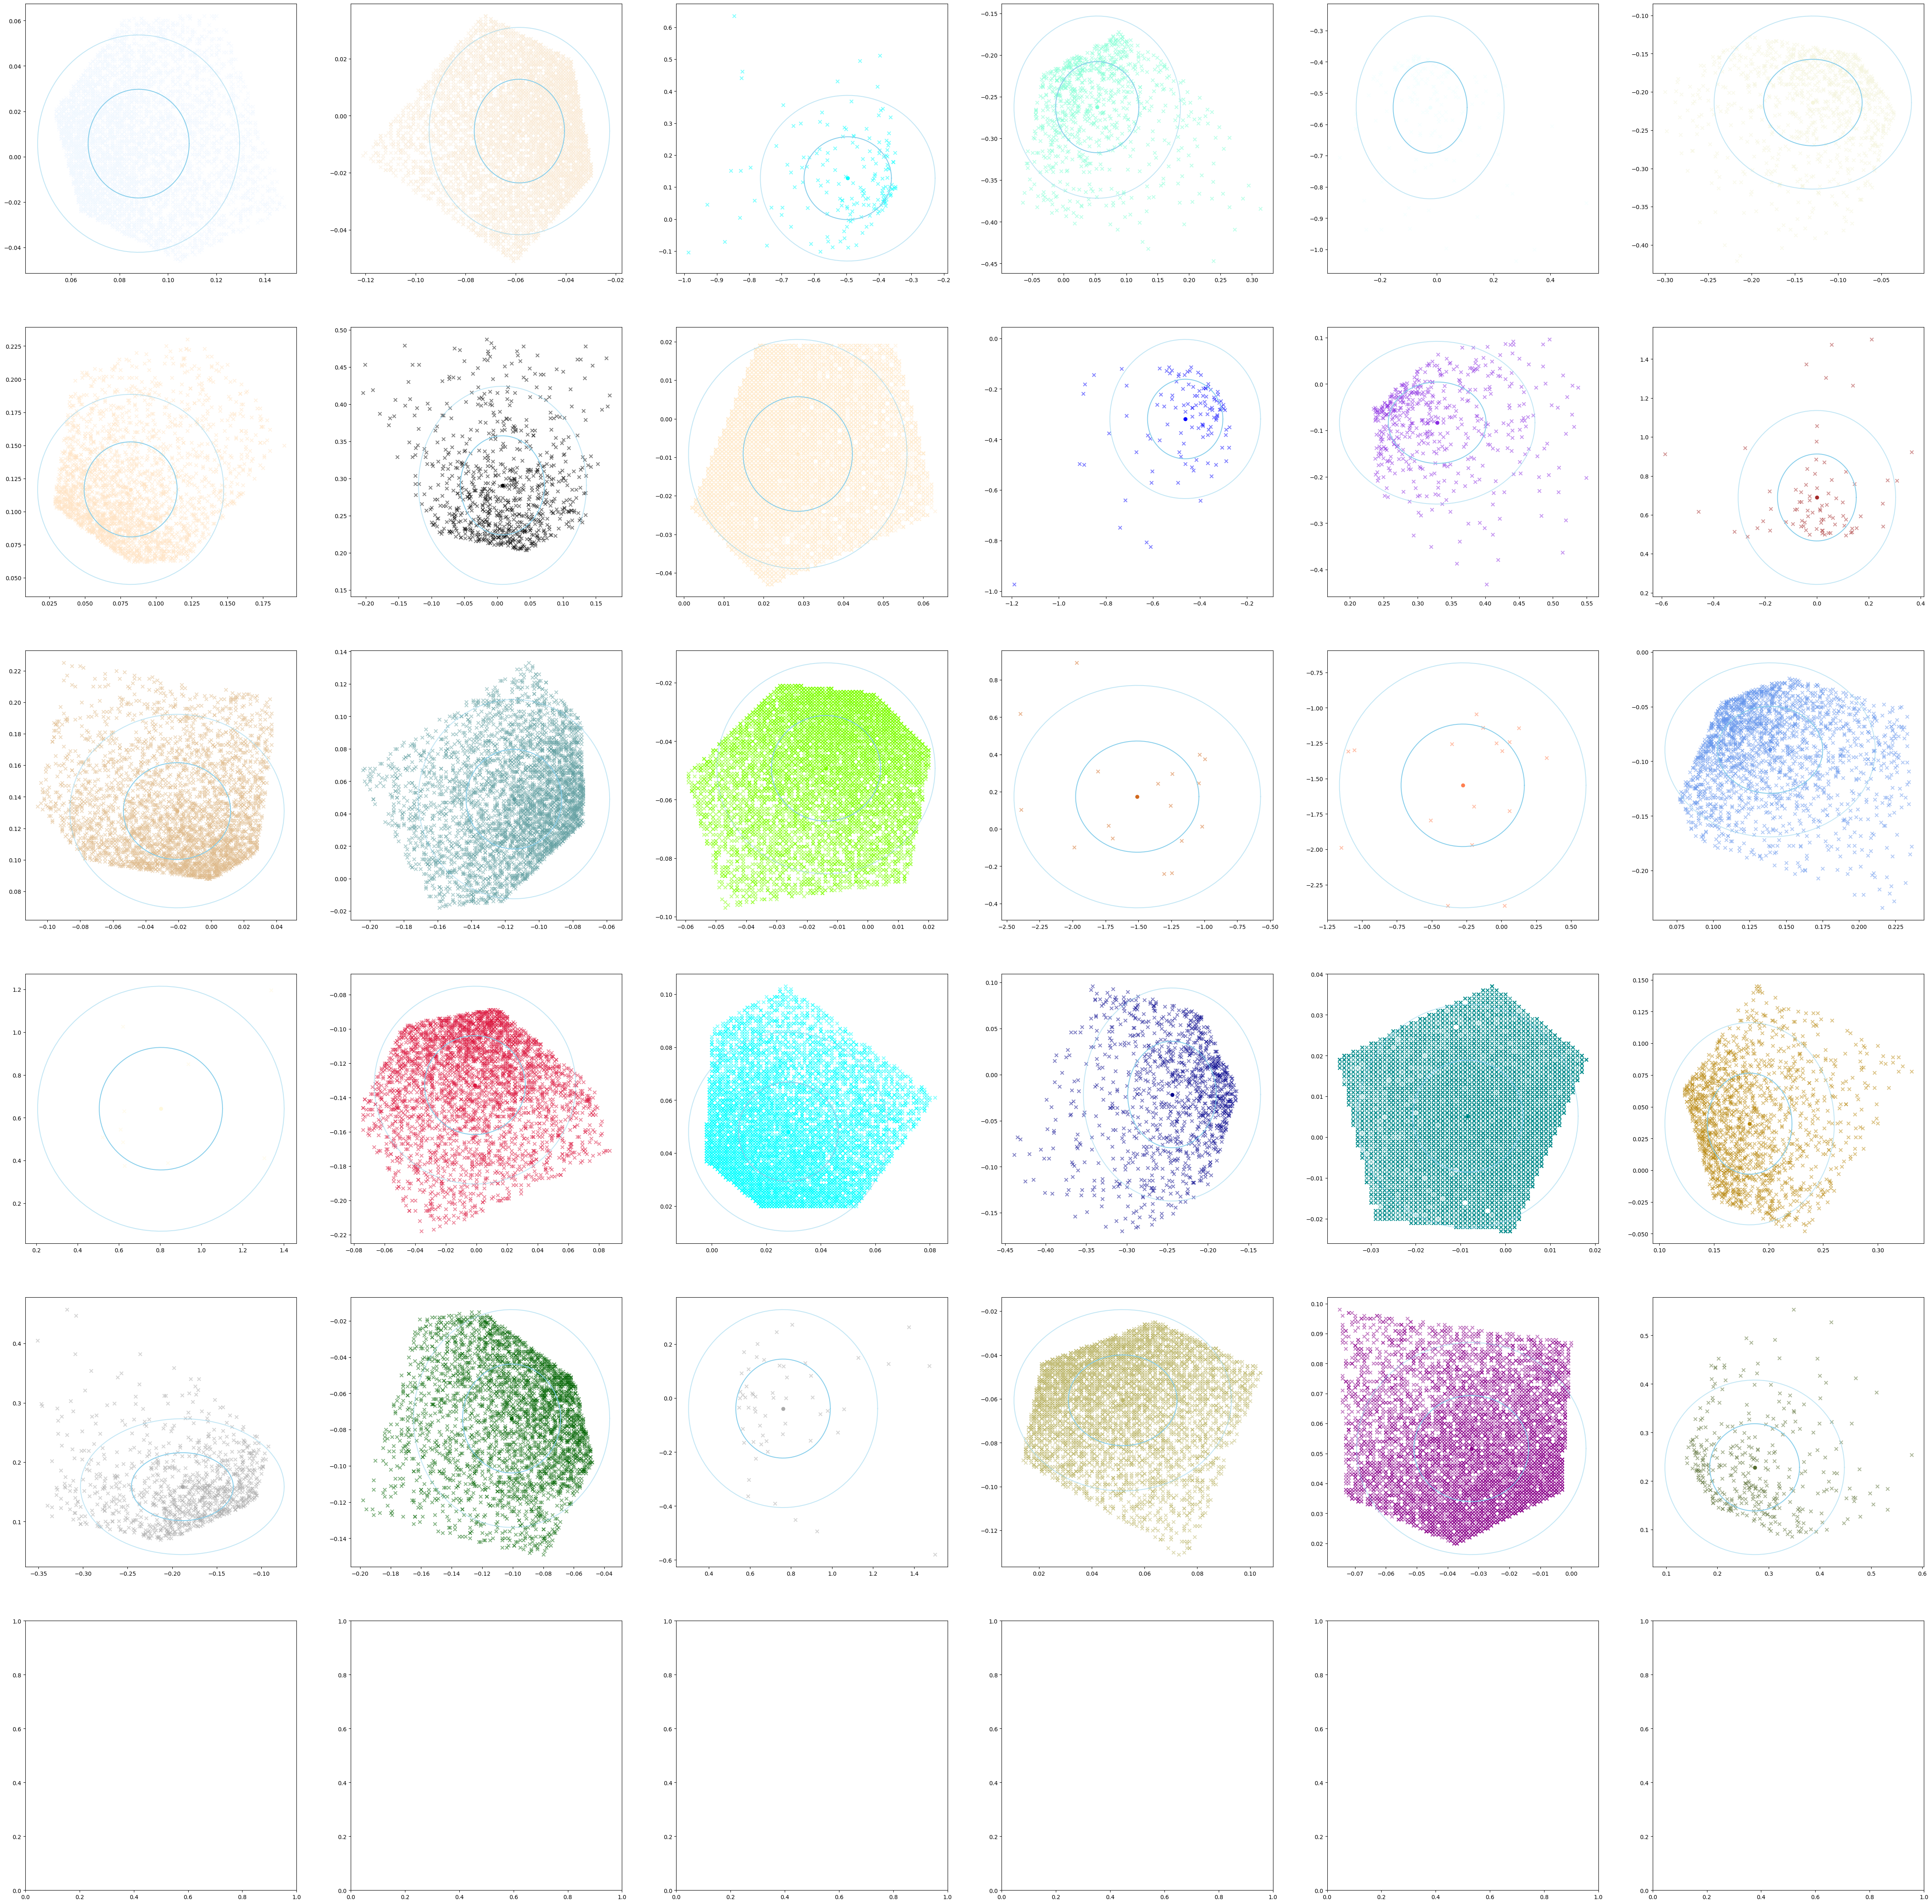

In [58]:
import math

theta = np.linspace(0, 2*np.pi, 100)

if label_num_k >= len(colors):
    raise ValueError("color variation is less than labels")

n = math.ceil(math.sqrt(label_num_k))
fig, axis = plt.subplots(n, n, figsize=(10*n, 10*n))

for label in range(label_num_k):
    row, column = divmod(label, n)
    
    label_df = token_df.loc[labels == label]
    center = centers[label]
    c_diff = label_df - center
    mean = c_diff.mean()
    std = c_diff.std()
    l_min = c_diff.min()
    l_max = c_diff.max()

    x_circle = center[0] + std["open"] * np.cos(theta)
    y_circle = center[1] + std["close"] * np.sin(theta)
    x_circle_2 = center[0] + std["open"] *2* np.cos(theta)
    y_circle_2 = center[1] + std["close"] *2* np.sin(theta)

    axis[row, column].scatter(label_df["open"], label_df["close"], color=colors[label], marker="x", alpha=0.5)
    axis[row, column].plot(x_circle, y_circle,  color='skyblue')
    axis[row, column].plot(x_circle_2, y_circle_2,  color='skyblue', alpha=0.5)
    # center is plotted with "o"
    axis[row, column].scatter(center[0], center[1], color=colors[label])
fig.show()

Caliculate probability of original value

In [60]:
observations = token_df.iloc[:60]
prediction = token_df.iloc[60:70]

In [61]:
def to_labels(predictions, centers):
    if isinstance(predictions, pd.DataFrame):
        predictions = predictions.values
    dist = ((predictions[:, :, np.newaxis] - centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
    labels = dist.argmin(axis = 1)
    return labels

In [62]:
pre_labels = to_labels(prediction, centers)
pre_labels

array([14, 25,  1, 22,  8, 22, 20,  8, 22,  8], dtype=int64)

use pdf of normal distribution for simply

In [63]:
def to_density_params(df, labels, centers):
    params = []
    for label in range(len(centers)):
        label_df = df.loc[labels==label]
        center = centers[label]
        c_diff = label_df - center
        mean = c_diff.mean().values
        std = c_diff.std().values
        l_min = c_diff.min().values
        l_max = c_diff.max().values
        params.append([label, center[0], center[1], mean[0], mean[1], std[0], std[1], l_min[0], l_min[1], l_max[0], l_max[1]])
    params_df = pd.DataFrame(params, columns=["label", "cx", "cy", "meanx", "meany", "stdx", "stdy", "minx", "miny", "maxx", "maxy"])
    return params_df

In [64]:
params_df = to_density_params(token_df, labels, centers)

In [65]:
params_df

label        cx        cy         meanx         meany      stdx      stdy  \
0       0  0.087919  0.005761  3.742325e-18  9.550725e-19  0.020856  0.023959   
1       1 -0.058516 -0.005377  1.130286e-19  7.064285e-19  0.018047  0.018199   
2       2 -0.496143  0.127798  1.982541e-17  0.000000e+00  0.134736  0.129541   
3       3  0.053731 -0.262374  6.321555e-18 -1.685748e-17  0.066318  0.054663   
4       4 -0.023701 -0.545799 -2.707861e-18  3.249433e-17  0.130641  0.146101   
5       5 -0.129208 -0.213873  1.395297e-17  1.443410e-18  0.056990  0.056550   
6       6  0.082113  0.116685  1.013589e-17  9.964091e-18  0.032696  0.035911   
7       7  0.007948  0.290829 -5.077239e-18 -2.112132e-17  0.063887  0.066598   
8       8  0.028551 -0.009156 -1.686548e-18  1.172678e-18  0.013703  0.014872   
9       9 -0.462291 -0.318974  1.186136e-17 -1.470808e-17  0.160398  0.157310   
10     10  0.329014 -0.083484  4.808052e-17 -8.741914e-19  0.072257  0.087691   
11     11 -0.000278  0.689291 -2.810691e-18  5.059244e-17  0.152076  0.223388   
12     12 -0.020843  0.130948 -4.527446e-18  5.326407e-19  0.032750  0.030693   
13     13 -0.114834  0.048962  5.968302e-18  1.425266e-18  0.028310  0.030702   
14     14 -0.013764 -0.049265  1.791617e-18 -5.357458e-18  0.017970  0.018049   
15     15 -1.509059  0.173647 -5.224579e-17  1.795949e-17  0.468202  0.298550   
16     16 -0.277588 -1.547824  2.938826e-17  7.836868e-17  0.442747  0.432786   
17     17  0.139046 -0.089554  1.785711e-17  1.700677e-18  0.036067  0.039804   
18     18  0.803800  0.642100 -4.440892e-17  0.000000e+00  0.298884  0.286234   
19     19 -0.000941 -0.132843 -1.457768e-18 -6.493695e-18  0.032893  0.028833   
20     20  0.028108  0.048066  3.497051e-18  1.694073e-19  0.018333  0.018760   
21     21 -0.244181 -0.021586  3.605006e-17  1.386541e-18  0.054626  0.057845   
22     22 -0.008385  0.005190 -6.841826e-19  1.320472e-18  0.012315  0.013697   
23     23  0.182622  0.036694 -1.902058e-17  8.269818e-19  0.038826  0.039840   
24     24 -0.188544  0.158757 -1.055171e-17  1.376310e-18  0.057195  0.057212   
25     25 -0.100726 -0.073866 -5.125749e-18  2.562875e-18  0.032118  0.030061   
26     26  0.761357 -0.038482 -4.758099e-17  0.000000e+00  0.230314  0.183555   
27     27  0.051726 -0.060636  4.713489e-19  8.012931e-18  0.020608  0.020681   
28     28 -0.032346  0.051642  1.012746e-18 -6.751641e-19  0.018561  0.017691   
29     29  0.272799  0.228335  1.586033e-17  1.647034e-17  0.087618  0.089820   

        minx      miny      maxx      maxy  
0  -0.033919 -0.051761  0.060081  0.056239  
1  -0.062484 -0.045623  0.028516  0.040377  
2  -0.490857 -0.231798  0.147143  0.507202  
3  -0.118731 -0.184626  0.260269  0.090374  
4  -0.320299 -0.491201  0.550701  0.164799  
5  -0.170792 -0.207127  0.093208  0.085873  
6  -0.053113 -0.054685  0.107887  0.113315  
7  -0.211948 -0.086829  0.163052  0.196171  
8  -0.026551 -0.033844  0.034449  0.028156  
9  -0.728709 -0.654026  0.188291  0.204974  
10 -0.094014 -0.348516  0.219986  0.179484  
11 -0.586722 -0.200291  0.365278  0.811709  
12 -0.085157 -0.042948  0.057843  0.094052  
13 -0.089166 -0.066962  0.040834  0.084038  
14 -0.045236 -0.047735  0.033764  0.028265  
15 -0.888941 -0.414647  0.512059  0.718353  
16 -0.873412 -0.850176  0.602588  0.502824  
17 -0.062046 -0.144446  0.096954  0.065554  
18 -0.282800 -0.267100  0.535200  0.553900  
19 -0.073059 -0.085157  0.087941  0.043843  
20 -0.030108 -0.028066  0.053892  0.054934  
21 -0.194819 -0.148414  0.079181  0.117586  
22 -0.028615 -0.028190  0.026385  0.031810  
23 -0.059622 -0.084694  0.148378  0.108306  
24 -0.162456 -0.089757  0.096544  0.298243  
25 -0.097274 -0.075134  0.052726  0.058866  
26 -0.215357 -0.541518  0.740643  0.311482  
27 -0.037726 -0.070364  0.052274  0.035636  
28 -0.042654 -0.031642  0.032346  0.046358  
29 -0.132799 -0.142335  0.306201  0.324665

In [38]:
params_df["label"].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

In [67]:
def minimax(values, min_value, max_value, scale=(0, 1)):
    std = (values - min_value) / (max_value - min_value)
    scaled = std * (scale[1] - scale[0]) + scale[0]
    return scaled

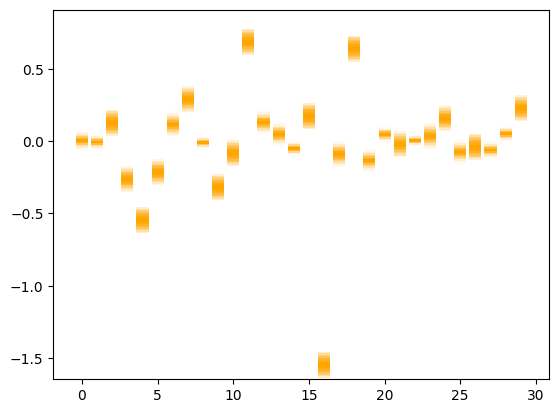

In [68]:
# see density of each cluster
from scipy.stats import norm

bin_edges = [step/100 for step in range(-10, 11)]

for label in params_df["label"].values:
    param_df = params_df[params_df["label"]==label]
    center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
    mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
    std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])

    density = np.array([
        norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std)
        for edge_i in range(len(bin_edges) -1)
    ])
    actual_edges = bin_edges + np.array(np.reshape(center, (2,1)))
    
    scaled_density = minimax(density[:, 1], density[:, 1].min(), density[:, 1].max())
    for index, edge in enumerate(actual_edges[1][:-1]):
        d = scaled_density[index]
        y_low = edge
        height = 0.01
        plt.bar([label], bottom=y_low, height=height, alpha=d, color="orange")
plt.show()

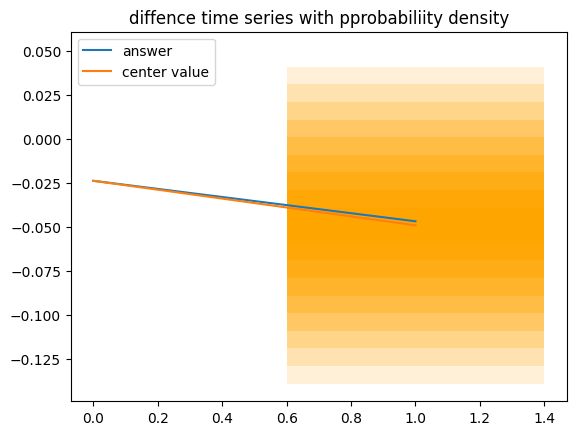

In [70]:
label = pre_labels[0]
bin_edges = [step/100 for step in range(-10, 11)]

param_df = params_df[params_df["label"]==label]
center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])

density = np.array([
    norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std) for edge_i in range(len(bin_edges) -1)
])

actual_edges = bin_edges + np.array(np.reshape(center, (2,1)))
scaled_density = minimax(density[:, 1], density[:, 1].min(), density[:, 1].max())

close = observations.iloc[-1]["close"]
pre_close = np.array(center)[1]
actual_close = prediction.iloc[0]["close"]
plt.plot([0, 1], [close, actual_close], label="answer")
plt.plot([0, 1], [close, pre_close], label="center value")
for index, edge in enumerate(actual_edges[1][:-1]):
    d = scaled_density[index]
    y_low = edge
    height = 0.01
    plt.bar([1], bottom=y_low, height=height, alpha=d, color="orange")
plt.title("diffence time series with pprobabiliity density")
plt.legend()
plt.show()

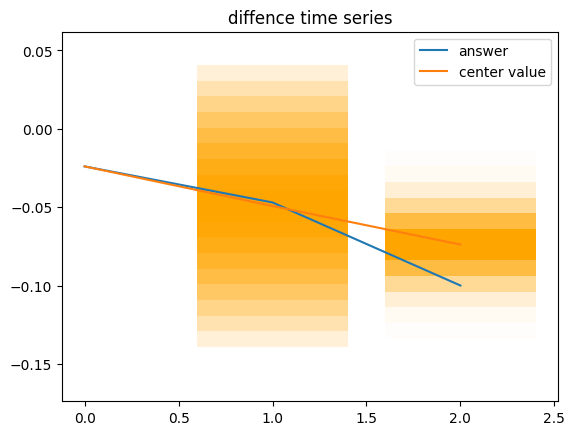

In [56]:
# see independent probability of two labels
label_index = 1
next_label = pre_labels[label_index]

param_df = params_df[params_df["label"]==next_label]
next_center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
next_mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
next_std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])

next_density = np.array([
    norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std)
    for edge_i in range(len(bin_edges) -1)
])
next_actual_edges = bin_edges + np.array(np.reshape(next_center, (2,1)))

next_scaled_density = minimax(next_density[:,1], next_density[:,1].min(), next_density[:,1].max())
close = observations.iloc[-1]["close"]
pre_close = [center[1], next_center[1]]
actual_close = prediction.iloc[:2]["close"].values
plt.plot([0, 1, 2], [close, *actual_close], label="answer")
plt.plot([0, 1, 2], [close, *pre_close], label="center value")
for index, edge in enumerate(actual_edges[1][:-1]):
    d = scaled_density[index]
    y_low = edge
    height = 0.01
    plt.bar([1], bottom=y_low, height=height, alpha=d, color="orange")
for index, edge in enumerate(next_actual_edges[1][:-1]):
    d = next_scaled_density[index]
    y_low = edge
    height = 0.01
    plt.bar([2], bottom=y_low, height=height, alpha=d, color="orange")
plt.title("diffence time series")
plt.legend()
plt.show()

In [448]:
label = pre_labels[0]
next_label = pre_labels[1]

bin_edges = [step/100 for step in range(-10, 11)]

param_df = params_df[params_df["label"]==label]
center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])


param_df = params_df[params_df["label"]==next_label]
next_center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
next_mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
next_std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])

density = []
all_centers = []
for edge_i in range(len(bin_edges) -1):
    center_i = (bin_edges[edge_i + 1] + bin_edges[edge_i])/2
    for edge_j in range(len(bin_edges) -1):
        density.append(
            (norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std)) * \
            (norm.cdf(bin_edges[edge_j + 1], next_mean, next_std) - norm.cdf(bin_edges[edge_j], next_mean, next_std))
        )
        center_j = (bin_edges[edge_j + 1] + bin_edges[edge_j])/2
        # this is not accurate caliculation as I ignored width between edges
        all_centers.append(center_i + center_j)
density = np.asarray(density)
density[:, 0].sum()

0.9981510047616438

In [449]:
# round center values to grouping it
all_edges_df = pd.DataFrame(all_centers, columns=["diff_value"]).round(2)
density_df = pd.DataFrame(density, columns=["open", "close"])
joint_density_df = pd.concat([density_df, all_edges_df], axis=1)
joint_density_df = joint_density_df.groupby('diff_value')[['open', 'close']].sum().reset_index()
joint_density_df.head()

diff_value          open         close
0       -0.19  4.215973e-10  2.740017e-10
1       -0.18  7.425261e-09  4.813473e-09
2       -0.17  8.964722e-08  5.762340e-08
3       -0.16  8.082504e-07  5.167266e-07
4       -0.15  5.541447e-06  3.545670e-06

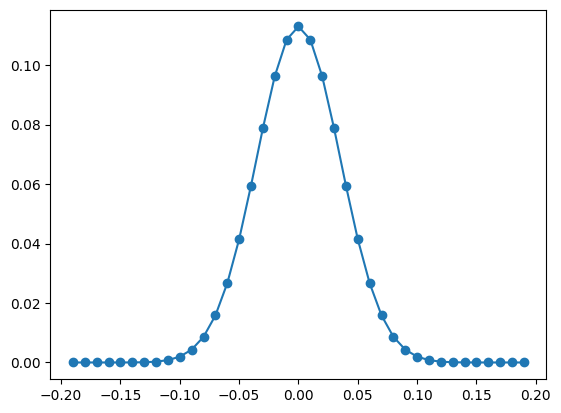

In [450]:
plt.plot(joint_density_df["diff_value"], joint_density_df["close"], marker="o")

plot reverted values with probability

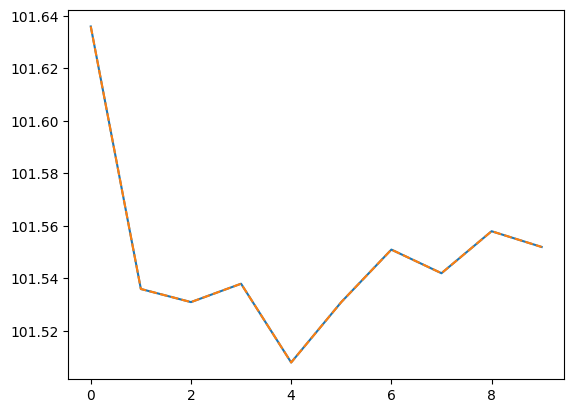

In [451]:
# we created token_df as df.diff()[["open", "close"]].dropna(). observation placed on .iloc[1:61]

revert_values_df = df["close"].iloc[60] + prediction["close"].cumsum()
answer_values_df = df["close"].iloc[61:71]
temp_indicies = [*range(10)]

plt.plot(temp_indicies, revert_values_df.values)
plt.plot(temp_indicies, answer_values_df.values, linestyle="--")
plt.show()

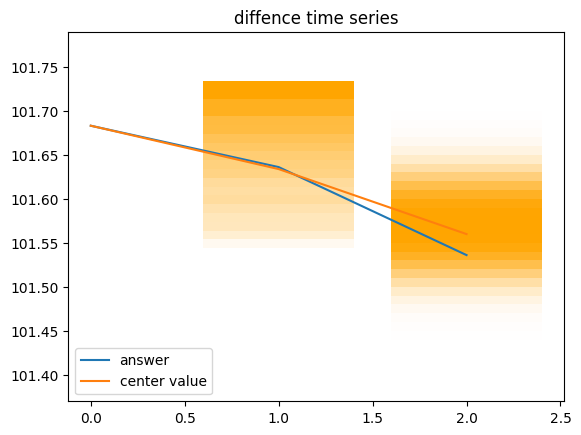

In [453]:
# see joint probability of two labels

next_scaled_pmass = minimax(joint_density_df["close"], joint_density_df["close"].min(), joint_density_df["close"].max())
close = df["close"].iloc[60]
actual_close = close + prediction.iloc[:2]["close"].cumsum().values

pre_close = []
diff = 0
for c in [center[1], next_center[1]]:
    diff += c
    pre_close.append(close + diff)
    
plt.plot([0, 1, 2], [close, *actual_close], label="answer")
plt.plot([0, 1, 2], [close, *pre_close], label="center value")

for index, edge in enumerate(actual_edges[1][:-1]):
    d = scaled_density[index]
    y_low = close + edge
    height = 0.01
    plt.bar([1], bottom=y_low, height=height, alpha=d, color="orange")

base_value = close + center[1] + next_center[1]
for index in range(len(joint_density_df)):
    d = next_scaled_pmass[index]
    y_low = base_value + joint_density_df["diff_value"].iloc[index]
    height = 0.02
    plt.bar([2], bottom=y_low, height=height, alpha=d, color="orange")

plt.title("diffence time series")
plt.legend()
plt.show()

use pmf caliculated based on actual lcluster values instead of normal distribution

In [62]:
# Freedman–Diaconis rule. Sometimes 0 count appeare due to outfliers.
def freedamn_diaconis_bins(data):
    q75, q25 = np.percentile(data, [75 ,25])

    iqr = q75 - q25
    n = len(data)
    bin_width = (2.0 * iqr / (n**(1/3)))
    return bin_width

def prob_mass(data, bin_width=None):
    if bin_width is None:
        counts, bin_edges = np.histogram(data)
    else:
        bins=np.arange(min(data), max(data) + bin_width, bin_width)
        counts, bin_edges = np.histogram(data, bins=bins)
    mass = counts / counts.sum()
    return mass, bin_edges

In [455]:
class Cluster:
    
    def __init__(self, label_df, center):
        self.center = center
        
        columns = token_df.columns
        self.pmass = {}
        self.bin_edges = {}
        self.min = label_df.min()
        self.max = label_df.max()
        self.bin_width = {}
        
        for column in columns:
            column_srs = label_df[column]
            bin_width = freedamn_diaconis_bins(column_srs).round(3)
            pmass, bin_edges = prob_mass(column_srs, bin_width)
            self.pmass[column] = pmass
            self.bin_edges[column] = bin_edges
            self.bin_width[column] = bin_width

In [435]:
clusters = []

for label in range(label_num_k):
    label_df = token_df[labels == label]
    center = centers[label]
    clusters.append(Cluster(label_df, center))

In [436]:
def to_labels(predictions, centers):
    if isinstance(predictions, pd.DataFrame):
        predictions = predictions.values
    dist = ((predictions[:, :, np.newaxis] - centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
    labels = dist.argmin(axis = 1)
    return labels

In [437]:
observations = token_df.iloc[:60]
prediction = token_df.iloc[60:70]

In [438]:
pre_labels = to_labels(prediction, centers)
pre_labels

array([14, 25,  1, 22,  8, 22, 20,  8, 22,  8], dtype=int64)

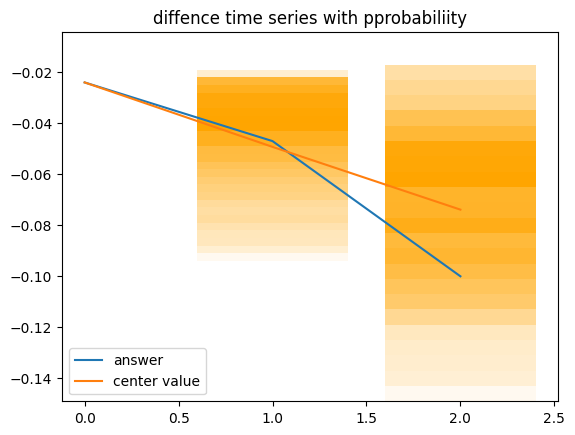

In [439]:
label = pre_labels[0]
cluster = clusters[label]
cluster_center = cluster.center
bin_edges = cluster.bin_edges["close"]
pmass = cluster.pmass["close"]

next_label = pre_labels[1]
next_cluster = clusters[next_label]
next_cluster_center = next_cluster.center
next_bin_edges = next_cluster.bin_edges["close"]
next_pmass = next_cluster.pmass["close"]

scaled_density = minimax(pmass, pmass.min(), pmass.max())
next_scaled_density = minimax(next_pmass, next_pmass.min(), next_pmass.max())

close = observations.iloc[-1]["close"]
pre_close = [cluster_center[1], next_cluster_center[1]]

actual_close = prediction.iloc[:2]["close"]
plt.plot([0, 1, 2], [close, *actual_close], label="answer")
plt.plot([0, 1, 2], [close, *pre_close], label="center value")
for index, bin_edge in enumerate(bin_edges[:-1]):
    d = scaled_density[index]
    y_low = bin_edge
    next_edge = bin_edges[index+1]
    height = next_edge - bin_edge
    plt.bar([1], bottom=y_low, height=height, alpha=d, color="orange")
    
for index, bin_edge in enumerate(next_bin_edges[:-1]):
    d = next_scaled_density[index]
    y_low = bin_edge
    next_edge = next_bin_edges[index+1]
    height = next_edge - bin_edge
    plt.bar([2], bottom=y_low, height=height, alpha=d, color="orange")
plt.title("diffence time series with pprobabiliity")
plt.legend()
plt.show()

In [440]:
label = pre_labels[0]
next_label = pre_labels[1]

cluster = clusters[label]
cluster_center = cluster.center
bin_edges = cluster.bin_edges["close"]
bin_width = cluster.bin_width["close"]
pmass = cluster.pmass["close"]

next_cluster = clusters[next_label]
next_cluster_center = next_cluster.center
next_bin_edges = next_cluster.bin_edges["close"]
next_bin_width = next_cluster.bin_width["close"]
next_pmass = next_cluster.pmass["close"]

density = []
all_centers = []
for index_i, edge_i in enumerate(bin_edges[:-1]):
    left_edge = edge_i
    right_edge = bin_edges[index_i+1]
    
    for index_j, edge_j in enumerate(next_bin_edges[:-1]):
        density.append(pmass[index_i] * next_pmass[index_j])
        next_left_edge = edge_j
        next_right_edge = next_bin_edges[index_j]
        
        joint_left_edge = left_edge + next_left_edge
        joint_right_edge = right_edge + next_right_edge
        
        joint_center = (joint_left_edge + joint_right_edge)/2
        all_centers.append(joint_center)
density = np.asarray(density)
density.sum()

1.0

In [441]:
# round center values to grouping it
all_edges_df = pd.DataFrame(all_centers, columns=["diff_value"])
density_df = pd.DataFrame(density, columns=["close"])
joint_density_df = pd.concat([density_df, all_edges_df], axis=1)
joint_density_df = joint_density_df.groupby('diff_value')['close'].sum().reset_index()
joint_density_df.sort_values(by="diff_value")
joint_density_df.head()

diff_value     close
0     -0.2445  0.000007
1     -0.2415  0.000031
2     -0.2385  0.000097
3     -0.2355  0.000185
4     -0.2325  0.000318

In [443]:
basic_width = bin_width + next_bin_width
min_value = joint_density_df["diff_value"].iloc[0]
max_value = joint_density_df["diff_value"].iloc[-1]
temp_df = joint_density_df.copy()

# devide by 2 as diff_value is center value
center_threshold = min_value + basic_width/2

joint_pmass = []
pmass_indices = []
while len(temp_df) > 0 and center_threshold <= max_value:
    possibilty_df = temp_df[temp_df["diff_value"] < center_threshold]
    if len(possibilty_df) > 0:
        possibilty = possibilty_df["close"].sum()
    else:
        possibilty = 0.0
    joint_pmass.append(possibilty)
    pmass_indices.append(center_threshold)
    
    temp_df = temp_df[temp_df["diff_value"] >= center_threshold]
    center_threshold += basic_width

C:\Users\sato\AppData\Local\Temp\ipykernel_21052\2880460360.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


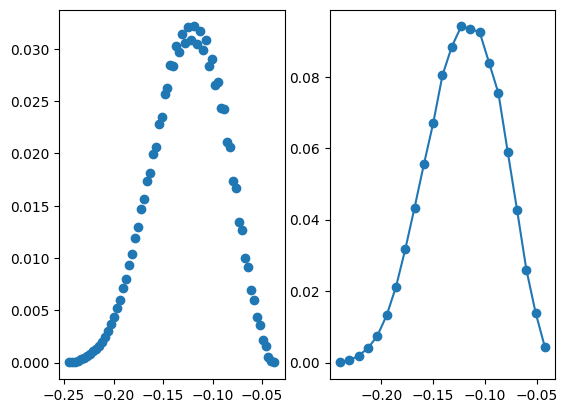

In [444]:
fig, axis = plt.subplots(1, 2)

axis[0].scatter(joint_density_df["diff_value"].values, joint_density_df["close"].values)
axis[1].plot(pmass_indices, joint_pmass, marker="o")
fig.show()

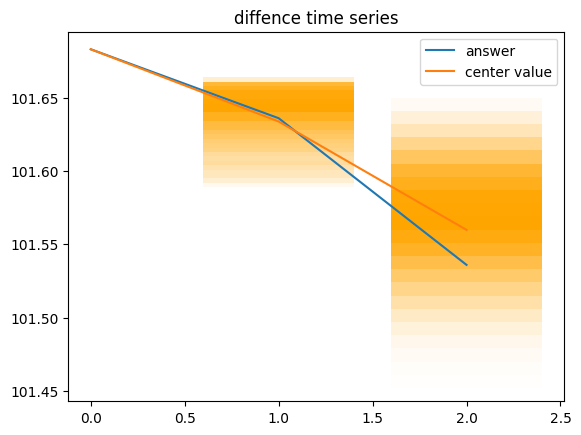

In [447]:
# see joint probability of two labels
scaled_density = minimax(pmass, pmass.min(), pmass.max())
next_scaled_pmass = minimax(joint_pmass, min(joint_pmass), max(joint_pmass))
close = df["close"].iloc[60]
actual_close = close + prediction.iloc[:2]["close"].cumsum().values

pre_close = []
diff = 0
for c in [cluster_center[1], next_cluster_center[1]]:
    diff += c
    pre_close.append(close + diff)
    
plt.plot([0, 1, 2], [close, *actual_close], label="answer")
plt.plot([0, 1, 2], [close, *pre_close], label="center value")

for index, edge in enumerate(bin_edges[:-1]):
    d = scaled_density[index]
    y_low = close + edge
    height = bin_width
    plt.bar([1], bottom=y_low, height=height, alpha=d, color="orange")

for index in range(len(pmass_indices)):
    d = next_scaled_pmass[index]
    y_low = close + pmass_indices[index]
    height = basic_width
    plt.bar([2], bottom=y_low, height=height, alpha=d, color="orange")

plt.title("diffence time series")
plt.legend()
plt.show()

In [63]:
class ClusterPossibility:
    
    def __init__(self, label_df, center, **kwargs):
        self.center = center
        if label_df is not None and len(label_df) > 0:
            columns = label_df.columns
            self.pmass = {}
            self.bin_edges = {}
            self.min = label_df.min()
            self.max = label_df.max()
            self.bin_width = {}
            
            for column in columns:
                column_srs = label_df[column]
                bin_width = freedamn_diaconis_bins(column_srs).round(3)
                pmass, bin_edges = prob_mass(column_srs, bin_width)
                self.pmass[column] = pmass
                self.bin_edges[column] = bin_edges
                self.bin_width[column] = bin_width
        elif "pmass" in kwargs:
            self.pmass = kwargs["pmass"]
            self.bin_edges = kwargs["bin_edges"]
            self.min = kwargs["min"]
            self.max = kwargs["max"]
            self.bin_width = kwargs["bin_width"]
        else:
            raise Exception(f"label_df is not valid: {type(label_df)}")
            
    def __rearrange_pmass_edges(self, pmass_df, width):
        min_value = pmass_df["diff_value"].iloc[0]
        max_value = pmass_df["diff_value"].iloc[-1]
        temp_df = pmass_df.copy()

        # devide by 2 as diff_value is center value
        center_threshold = min_value + width/2
        left_edge = min_value
        right_edge = min_value + width
        
        bin_edges = [left_edge]
        joint_pmass = []
        pmass_indices = []
        while len(temp_df) > 0 and center_threshold <= max_value:
            possibilty_df = temp_df[temp_df["diff_value"] < center_threshold]
            if len(possibilty_df) > 0:
                possibilty = possibilty_df.loc[:, temp_df.columns != "diff_value"].sum()
            else:
                possibilty = 0.0
            joint_pmass.append(possibilty.values)
            pmass_indices.append(center_threshold)
            bin_edges.append(right_edge)
            
            left_edge = right_edge
            right_edge += width
            
            temp_df = temp_df[temp_df["diff_value"] >= center_threshold]
            center_threshold += width
        diff_values = pd.Series(pmass_indices, name="diff_value")
        pmass_df = pd.DataFrame(joint_pmass, columns=["probability"])
        pmass_df = pd.concat([diff_values, pmass_df], axis=1)
        return pmass_df, np.asarray(bin_edges)
            
    def __joint_probability(self, pmass, bin_edges, pmass_2, bin_edges_2):
        joint_pmass = []
        all_centers = []
        width = min(bin_edges[1:] - bin_edges[:-1])
        width_2 = min(bin_edges_2[1:] - bin_edges_2[:-1])
        
        for index_i, edge_i in enumerate(bin_edges[:-1]):
            left_edge = edge_i
            right_edge = bin_edges[index_i+1]
            
            for index_j, edge_j in enumerate(bin_edges_2[:-1]):
                joint_pmass.append(pmass[index_i] * pmass_2[index_j])
                next_left_edge = edge_j
                next_right_edge = bin_edges_2[index_j]
                
                joint_left_edge = left_edge + next_left_edge
                joint_right_edge = right_edge + next_right_edge
                
                joint_center = (joint_left_edge + joint_right_edge)/2
                all_centers.append(joint_center)

        all_edges_df = pd.Series(all_centers, name="diff_value")
        joint_pmass_df = pd.Series(joint_pmass, name="probability")
        joint_pmass_df = pd.concat([joint_pmass_df, all_edges_df], axis=1)
        joint_pmass_df = joint_pmass_df.groupby('diff_value').sum().reset_index()
        joint_pmass_df.sort_values(by="diff_value")
        joint_width = width + width_2
        joint_pmass_df, joint_bin_edges = self.__rearrange_pmass_edges(joint_pmass_df, joint_width)
        return joint_pmass_df, joint_bin_edges, joint_width
            
    def __mul__(self, other):
        if isinstance(other, ClusterPossibility):
            columns = set([*self.pmass.keys(), *other.pmass.keys()])
            joint_pmass = {}
            joint_bin_edges = {}
            joint_min = {}
            joint_max = {}
            joint_bin_width = {}
            joint_center = {}
            
            if len(columns) > 0:
                for index, column in enumerate(columns):
                    pmass_df, bin_edges, width = self.__joint_probability(self.pmass[column], self.bin_edges[column], 
                                                                          other.pmass[column], other.bin_edges[column])
                    pmass = pmass_df["probability"].values
                    joint_pmass[column] = pmass
                    joint_bin_edges[column] = bin_edges
                    joint_min[column] = pmass[0]
                    joint_max[column] = pmass[-1]
                    joint_bin_width[column] = width
                    if isinstance(self.center, (pd.DataFrame, dict)) and column in self.center:
                        center = self.center[column]
                    else:
                        center = self.center[index]
                    if isinstance(other.center, (pd.DataFrame, dict)) and column in other.center:
                        other_center = other.center[column]
                    else:
                        other_center = other.center[index]
                    joint_center[column] = center+other_center
                joint_cluster = ClusterPossibility(None, center=joint_center, pmass=joint_pmass, bin_edges=joint_bin_edges,
                                   min=joint_min, max=joint_max, bin_width=joint_bin_width)
                return joint_cluster   
            else:
                raise ValueError("clusters don't have any same columns.")
        else:
            raise TypeError("Unsupported operand type")
        
    def __getitem__(self, ndx):
        if isinstance(ndx, str):
            return self.pmass[ndx], self.bin_edges[ndx]
        else:
            partial_pmass = {}
            partial_bins = {}
            for key in self.pmass.keys():
                partial_pmass[key] = self.pmass[key][ndx]
                partial_bins[key] = self.bin_edges[key][ndx]
            return partial_pmass, partial_bins

In [534]:
clusters = []

for label in range(label_num_k):
    label_df = token_df[labels == label]
    center = centers[label]
    clusters.append(ClusterPossibility(label_df, center))

In [536]:
new_cluster = clusters[0] * clusters[1] * clusters[2]

In [546]:
prob, bin_edges = new_cluster[:]
prob, bin_edges

({'close': array([0.00095572, 0.03747866, 0.08332968, 0.19297699, 0.22133484,
         0.16386886, 0.12645238, 0.08199833, 0.04084489, 0.02123783,
         0.01838079, 0.00559774, 0.00405862, 0.00146372]),
  'open': array([1.27348212e-04, 7.38180319e-03, 9.99251853e-03, 2.94516389e-02,
         2.54590185e-02, 4.04766631e-02, 7.45129454e-02, 1.24034782e-01,
         1.70379735e-01, 2.77971997e-01, 2.07593433e-01, 3.25340087e-02])},
 {'close': array([-0.1955, -0.1315, -0.0675, -0.0035,  0.0605,  0.1245,  0.1885,
          0.2525,  0.3165,  0.3805,  0.4445,  0.5085,  0.5725,  0.6365,
          0.7005]),
  'open': array([-1.0485, -0.9795, -0.9105, -0.8415, -0.7725, -0.7035, -0.6345,
         -0.5655, -0.4965, -0.4275, -0.3585, -0.2895, -0.2205])})

Create Dataset class

In [8]:
import sys
sys.path.append("../Dataset")
from base import Dataset

f:\d_drive\workspace\stocknet_study\venv_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
import torch

class ClusterDataset(Dataset):
    
    def __init__(
        self,
        df,
        columns: list,
        label_num_k:int = 30,
        observation_length: int = 60,
        device="cuda",
        prediction_length=10,
        seed=1017,
        is_training=True,
        randomize=True,
        index_sampler=None,
        split_ratio=0.8,
        indices=None,
    ):
        diff_p = fprocess.DiffPreProcess(columns=columns)
        src_df = df[columns].dropna()
        src_df = diff_p(src_df)
        
        divisions = [i / (label_num_k-1) for i in range(label_num_k)]
        ini_centers = [
            np.quantile(src_df, p, axis=0) for p in divisions
        ]
        labels, centers = k_means(src_df, label_num_k=label_num_k, initial_centers=ini_centers)
        self.centers = centers
        for label in range(label_num_k):
            label_df = src_df[labels == label]
            center = centers[label]
            clusters.append(ClusterPossibility(label_df, center))
        self.clusters = clusters
        new_columns = ["label"]
        token_df = pd.DataFrame(labels, index=src_df.index, columns=new_columns)
        super().__init__(token_df, columns=new_columns, observation_length=observation_length, processes=None,
                         device=device, prediction_length=prediction_length, seed=seed, is_training=is_training, randomize=randomize,
                         index_sampler=index_sampler, split_ratio=split_ratio, indices=indices, dtype=torch.int)
        
    
    def to_labels(observations):
        if isinstance(observations, pd.DataFrame):
            observations = observations.values
        dist = ((observations[:, :, np.newaxis] - centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
        labels = dist.argmin(axis = 1)
        return labels

    def __getitem__(self, ndx):
        src = self._input_func(ndx)
        ans = self._output_func(ndx)
        src = src.squeeze()
        ans = ans.squeeze()
        return src, ans

In [ ]:
ds = ClusterDataset(df, columns=["open", "close"], randomize=False)

In [41]:
obs, ans = ds[:10]
emb = torch.nn.Embedding(30, 6, device="cuda")
src = emb(obs)
src[0]

tensor([[ 0.9693, -0.1666, -0.0942,  0.2706, -0.2022, -0.5432],
        [-1.2301, -0.8722,  0.4184, -1.0225, -0.2607, -0.3027],
        [-0.2882,  0.2441, -0.3876,  0.3711,  0.8546, -0.5025],
        [-0.6742,  0.3400, -2.2791, -1.2906, -0.8479, -0.0498],
        [-0.5572, -0.0617,  0.9653, -1.0353,  0.6517, -0.5067],
        [ 0.7102, -1.4346,  0.3847,  1.1705, -1.1856,  0.8345],
        [ 1.3624,  0.1547, -0.3988, -0.9179,  0.7045, -1.4199],
        [ 1.3624,  0.1547, -0.3988, -0.9179,  0.7045, -1.4199],
        [-1.3485,  0.5593, -0.3441,  0.7906, -0.6165, -0.1096],
        [ 1.3624,  0.1547, -0.3988, -0.9179,  0.7045, -1.4199]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [42]:
from base import TimeDataset

In [61]:
import torch

class ClusterDataset(TimeDataset):
    
    def __init__(
        self,
        df,
        columns: list,
        label_num_k:int = 30,
        observation_length: int = 60,
        device="cuda",
        prediction_length=10,
        seed=1017,
        is_training=True,
        randomize=True,
        index_sampler=None,
        split_ratio=0.8,
        indices=None,
    ):
        diff_p = fprocess.DiffPreProcess(columns=columns)
        src_df = df[columns].dropna()
        src_df = diff_p(src_df).dropna()
        
        divisions = [i / (label_num_k-1) for i in range(label_num_k)]
        ini_centers = [
            np.quantile(src_df, p, axis=0) for p in divisions
        ]
        labels, centers = k_means(src_df, label_num_k=label_num_k, initial_centers=ini_centers)
        self.centers = centers
        clusters = []
        for label in range(label_num_k):
            label_df = src_df[labels == label]
            center = centers[label]
            clusters.append(ClusterPossibility(label_df, center))
        self.clusters = clusters
        new_columns = ["label"]
        token_df = pd.DataFrame(labels, index=src_df.index, columns=new_columns)
        super().__init__(token_df, columns=new_columns, observation_length=observation_length, processes=None,
                         device=device, prediction_length=prediction_length, seed=seed, is_training=is_training, randomize=randomize,
                         index_sampler=index_sampler, split_ratio=split_ratio, indices=indices, dtype=torch.int)
        
    
    def to_labels(observations):
        if isinstance(observations, pd.DataFrame):
            observations = observations.values
        dist = ((observations[:, :, np.newaxis] - centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
        labels = dist.argmin(axis = 1)
        return labels

    def __getitem__(self, ndx):
        src, src_time = self._input_func(ndx)
        ans, ans_time = self._output_func(ndx)
        src = src.squeeze()
        ans = ans.squeeze()
        return (src, src_time), (ans, ans_time)

In [64]:
ds = ClusterDataset(df, columns=["open", "close"], randomize=False)

TypeError: __init__() got an unexpected keyword argument 'split_ratio'

In [ ]:
obs, ans = ds[:10]
emb = torch.nn.Embedding(30, 6, device="cuda")
src = emb(obs[0])
src[0]

## X-Means

In [18]:
from scipy.stats import norm
from scipy.stats import multivariate_normal

def log_likelihood(label_df, center, cov):
    return multivariate_normal.logpdf(label_df, center, cov).sum()

def bic(label_df, center, cov):
    size = len(label_df)
    df = size * (label_df.shape[1] + 3) / 2
    return -2 * log_likelihood(label_df, center, cov) + df * np.log(size)

def clusters_bic(c1:pd.DataFrame, c2: pd.DataFrame, centers):
    size = len(c1) + len(c2)
    df = size * (c1.shape[1] + 3) / 2
    
    c1_cov = c1.cov()
    c2_cov = c2.cov()
    c1_center = centers[0]
    c2_center = centers[1]
    
    beta = np.linalg.norm(c1_center - c2_center) / np.sqrt(np.linalg.det(c1_cov) + np.linalg.det(c2_cov))
    alpha = 0.5 / norm.cdf(beta)
    bic = -2 * (size * np.log(alpha) + log_likelihood(c1, c1_center, c1_cov) + log_likelihood(c2, c2_center, c2_cov)) + 2 * df * np.log(size)
    return bic

split vectors roughly
generally x-means split vectors to two clusters repeatedly. Here we split vectors to five clusters at first so that k-means split vectors around zero vectors and other 4 areas. 

In [15]:
from itertools import product

def create_binary_matrix(n, symbols:list):
    binary_combinations = list(product(symbols, repeat=n))
    binary_matrix = np.array(binary_combinations)

    return binary_matrix

n_dimension = 2
ini_centers = create_binary_matrix(n_dimension, [1.0, -1.0])
ini_centers = np.vstack([ini_centers, [0.0,0.0 ]])
ini_centers

array([[ 1.,  1.],
       [ 1., -1.],
       [-1.,  1.],
       [-1., -1.],
       [ 0.,  0.]])

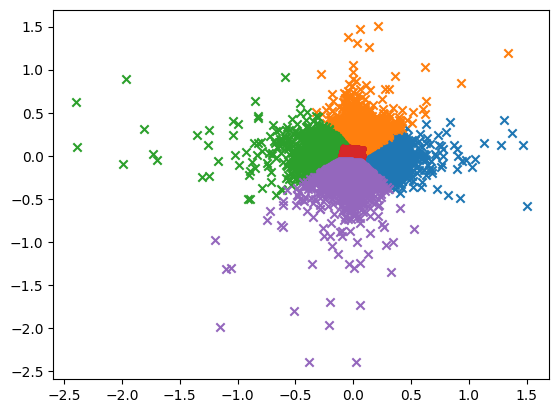

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = [*mcolors.TABLEAU_COLORS.values()]

labels, centers = k_means(src_df[["open", "close"]], label_num_k=len(ini_centers), initial_centers=ini_centers)
for label in range(len(centers)):
    label_df = src_df[["open", "close"]].loc[labels == label]
    plt.scatter(label_df["open"], label_df["close"], color=colors[label], marker="x")
    plt.scatter(centers[label][0], centers[label][1], color=colors[label])
plt.show()

Check if we can split pre clustered vectors based on bic threshold

In [19]:
label = 0
label_df = label_df = src_df[["open", "close"]].loc[labels == label].dropna()
center = centers[label]

label_bic = bic(label_df, center, label_df.cov())
label_bic

234982.51473025797

In [20]:
new_labels, new_centers = k_means(label_df, 2)
c1 = label_df.loc[new_labels == 0]
c2 = label_df.loc[new_labels == 1]

new_bic = clusters_bic(c1, c2, new_centers)
new_bic

528716.9122654499

In [22]:
# As bic is less than initial cluster, x-means end
label_bic > new_bic

False

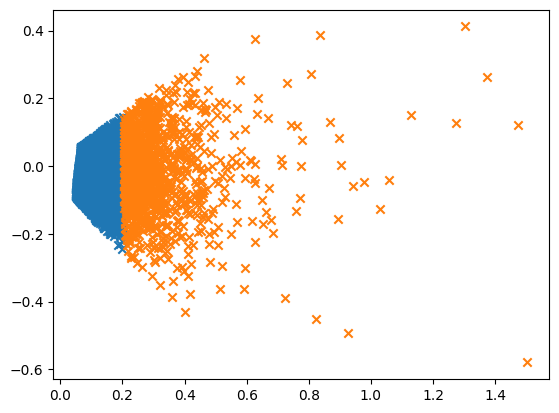

In [21]:
# Even if the data have outliers, x-means can't split it. May be it depends on initial centers though.
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = [*mcolors.TABLEAU_COLORS.values()]

for label in range(len(new_centers)):
    new_label_df = label_df[["open", "close"]].loc[new_labels == label]
    plt.scatter(new_label_df["open"], new_label_df["close"], color=colors[label], marker="x")
    plt.scatter(new_centers[label][0], new_centers[label][1], color=colors[label])
plt.show()